In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers, models, optimizers, callbacks, preprocessing

In [16]:
df = pd.read_csv('../../../data/deep_learning_recurrent_neural_networks_in_python/section_6/spam.csv', encoding='ISO-8859-1')

In [17]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [18]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [19]:
df.columns = ['labels', 'data']

In [20]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [21]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [22]:
# create tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((df_train.values, Ytrain))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.values, Ytest))

train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
# convert sentences to sequences
MAX_VOCAB_SIZE = 20000
vectorization = layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x, y: x))

In [24]:
# shuffle and batch the dataset
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
V = len(vectorization.get_vocabulary())

In [26]:
# create the model
D = 20 # Embedding dimensionality
M = 15 # Hidden layer size

# input is a string(text to analyze)
i = layers.Input(shape=(1,), dtype=tf.string)
x = vectorization(i)
x = layers.Embedding(V + 1, D)(x)
x = layers.LSTM(M, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(i, x)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(train_ds, validation_data=test_ds, epochs=10, verbose=2)

Epoch 1/10
117/117 - 3s - 29ms/step - accuracy: 0.8594 - loss: 0.4478 - val_accuracy: 0.8798 - val_loss: 0.3479
Epoch 2/10
117/117 - 1s - 11ms/step - accuracy: 0.9336 - loss: 0.2199 - val_accuracy: 0.9750 - val_loss: 0.1238
Epoch 3/10
117/117 - 1s - 11ms/step - accuracy: 0.9764 - loss: 0.1101 - val_accuracy: 0.9804 - val_loss: 0.0913
Epoch 4/10
117/117 - 1s - 11ms/step - accuracy: 0.9847 - loss: 0.0732 - val_accuracy: 0.9842 - val_loss: 0.0713
Epoch 5/10
117/117 - 1s - 11ms/step - accuracy: 0.9930 - loss: 0.0446 - val_accuracy: 0.9864 - val_loss: 0.0607
Epoch 6/10
117/117 - 1s - 12ms/step - accuracy: 0.9954 - loss: 0.0318 - val_accuracy: 0.9869 - val_loss: 0.0606
Epoch 7/10
117/117 - 1s - 11ms/step - accuracy: 0.9885 - loss: 0.0468 - val_accuracy: 0.9875 - val_loss: 0.0536
Epoch 8/10
117/117 - 1s - 11ms/step - accuracy: 0.9971 - loss: 0.0193 - val_accuracy: 0.9875 - val_loss: 0.0592
Epoch 9/10
117/117 - 1s - 11ms/step - accuracy: 0.9987 - loss: 0.0127 - val_accuracy: 0.9853 - val_loss:

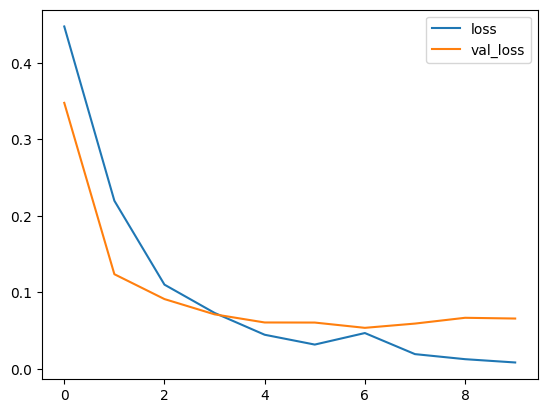

In [27]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

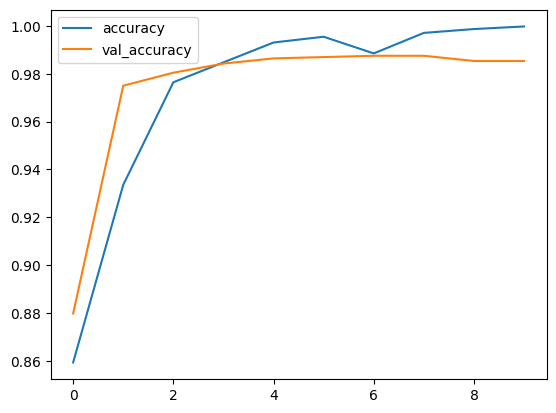

In [28]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

<Axes: >

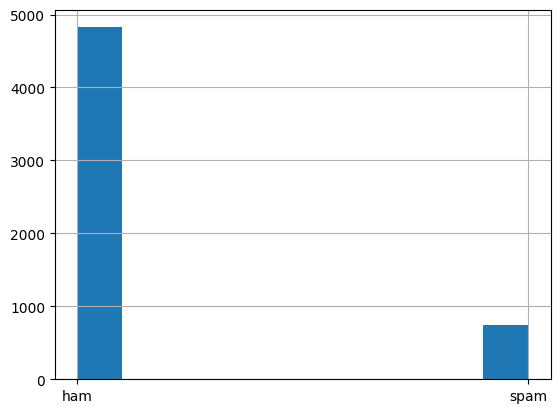

In [30]:
df['labels'].hist()
# So here we can see imbalanced data

In [32]:
from sklearn.metrics import f1_score
f1_score(Ytrain, (model.predict(df_train) > 0.5).astype('int'))

ValueError: Invalid dtype: object

In [33]:
f1_score(Ytest, (model.predict(df_test) > 0.5).astype('int'))

ValueError: Invalid dtype: object

In [34]:
train_ints = vectorization(np.array([[s] for s in df_train.values])).numpy()
test_ints = vectorization(np.array([[s] for s in df_test.values])).numpy()

train_ints.shape

(3733, 171)

In [36]:
# create tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_ints, Ytrain))
test_ds = tf.data.Dataset.from_tensor_slices((test_ints, Ytest))

train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(171,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
# shuffle and batch the dataset
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
# create the model
D = 20 # Embedding dimensionality
M = 15 # Hidden layer size

# input is a string(text to analyze)
i = layers.Input(shape=(None,))
x = layers.Embedding(V + 1, D)(i)
x = layers.LSTM(M, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(i, x)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(train_ds, validation_data=test_ds, epochs=10, verbose=2)

Epoch 1/10
117/117 - 6s - 50ms/step - accuracy: 0.8411 - loss: 0.5049 - val_accuracy: 0.9581 - val_loss: 0.2655
Epoch 2/10
117/117 - 4s - 35ms/step - accuracy: 0.9577 - loss: 0.2080 - val_accuracy: 0.9755 - val_loss: 0.1417
Epoch 3/10
117/117 - 4s - 35ms/step - accuracy: 0.9796 - loss: 0.1204 - val_accuracy: 0.9782 - val_loss: 0.1129
Epoch 4/10
117/117 - 4s - 35ms/step - accuracy: 0.9845 - loss: 0.0896 - val_accuracy: 0.9799 - val_loss: 0.0989
Epoch 5/10
117/117 - 4s - 35ms/step - accuracy: 0.9877 - loss: 0.0668 - val_accuracy: 0.9804 - val_loss: 0.0829
Epoch 6/10
117/117 - 4s - 34ms/step - accuracy: 0.9786 - loss: 0.0901 - val_accuracy: 0.9728 - val_loss: 0.1055
Epoch 7/10
117/117 - 4s - 34ms/step - accuracy: 0.9898 - loss: 0.0486 - val_accuracy: 0.9826 - val_loss: 0.0760
Epoch 8/10
117/117 - 4s - 34ms/step - accuracy: 0.9928 - loss: 0.0384 - val_accuracy: 0.9837 - val_loss: 0.0714
Epoch 9/10
117/117 - 4s - 34ms/step - accuracy: 0.9930 - loss: 0.0340 - val_accuracy: 0.9826 - val_loss: